#

# Velocity and pyGSEA calculations of ESR1

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  **CNV Score & Numbat to quantify and Velocity quantification with loom file**
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment

The notebook focuses on RNA velocity analysis, which is a method used to predict the future state of individual cells based on the ratio of unspliced to spliced mRNA transcripts. In the context of this study, it helps determine the "transcriptional direction" or momentum of cells following promoter-specific perturbations. 

RNA velocity analysis requires quantifying two types of mRNA: spliced (mature) and unspliced (precursor).


What is happening: The notebook utilizes the tool velocyto to process the raw BAM files generated by Cell Ranger into a .loom file format.

The Logic: Unspliced mRNA represents "new" transcription, while spliced mRNA represents the current "pool" of mature transcripts. By comparing these, the model can infer whether a gene is being actively upregulated or downregulated in a specific cell.

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="/Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import scvelo as scv

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import gseapy as gp

# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'
# %%capture


# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Scanpy", sc.__version__)
%matplotlib inline

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scanpy 1.10.3


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
%%capture
adata_rna  = ad.read_h5ad(loc+"files/adata_normalised_cellcycle.h5ad")
adata_rna.X=adata_rna.layers["log1p"]

#get the adata_rna.obs and merge it with adata.obs
adata_1 = scv.read('/Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/cellranger_output/AP_CRISPR_WHOLE_ENSEMBL.loom', cache=True)
adata_1.obs.index=adata_1.obs.index.str.split(":").str.get(1).str[:-1]+"-1"
#get only the adata_rna.obs and subset adata 
adata_2= scv.read('/Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/cellranger_output_rerun/AP_CRISPR_WHOLE_ENSEMBL.loom', cache=True)
adata_2.obs.index=adata_2.obs.index.str.split(":").str.get(1).str[:-1]+"-1"

#merge  adata_1 and adata_2 with the same cellbarcodes scv 
adata = scv.utils.merge(adata_1, adata_2)

adata = adata[adata_rna.obs.index,:]
adata.obs=pd.merge(adata.obs, adata_rna.obs, left_index=True, right_index=True).set_index("cell_barcode")

In [24]:
scv.pl.proportions(adata)


In [25]:
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
sc.pp.log1p(adata)

Extracted 2000 highly variable genes.


In [30]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
# scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
# scv.tl.velocity(adata,min_r2=0.0001,min_likelihood=0.00001, use_highly_variable=False)
scv.tl.velocity(adata,min_r2=0.001,min_likelihood=0.001, use_highly_variable=False)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


computing velocity graph (using 1/12 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site

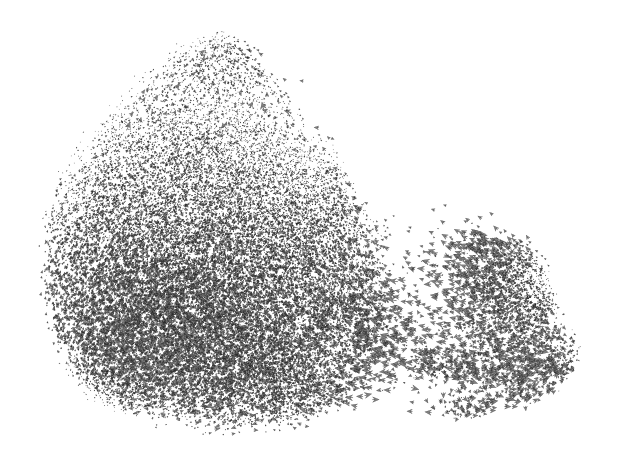

In [31]:
scv.tl.velocity_graph(adata)
#run & calculate umap
scv.tl.umap(adata)
adata.obs["negative"]= np.where(adata.obs["guide_id"]=="non-targeting_Control","non_targeting","knockdown")

scv.pl.velocity_embedding_stream(adata, basis='umap', color='negative', dpi=120)
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)
scv.tl.velocity_pseudotime(adata)


In [32]:
#subset adata just for esr1 
# adata_esr1=adata[adata.obs["guide_id"].isin(["ESR1_MP","ESR1_AP"])]
adata_esr1=adata[adata.obs["guide_id"].isin(["ESR1_AP","ESR1_MP","non-targeting_Control"])] 

sc.tl.umap(adata_esr1)
scv.pl.velocity_embedding_stream(adata_esr1, basis='umap', color='guide_id', save="output.svg", dpi=600)
scv.pl.scatter(adata_esr1, color='velocity_pseudotime', cmap='gnuplot', save="esr1_stream_pseudotime.pdf")


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site

saving figure to file ./figures/scvelo_output.svg


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site

saving figure to file ./figures/scvelo_esr1_stream_pseudotime.pdf


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 40, 42, 53, 54, 68, 70, 71, 72, 75, 76, 78, 80, 81, 82, 85, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 

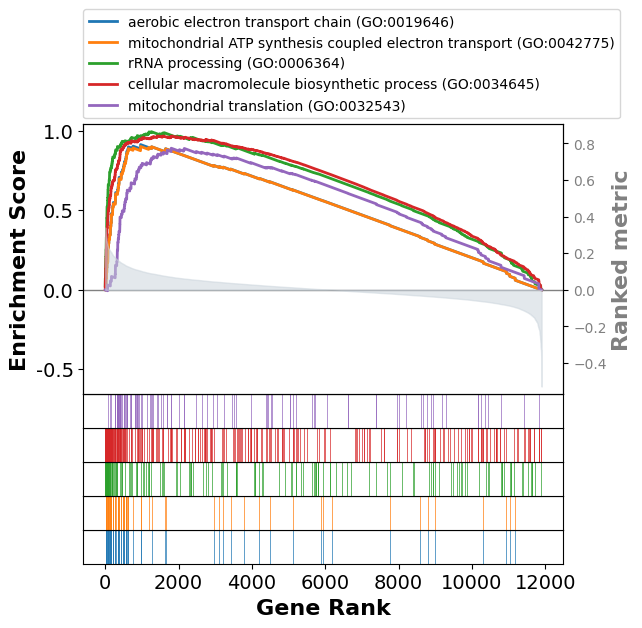

In [15]:
adata_esr1=adata_rna[adata_rna.obs["guide_id"].isin(["ESR1_AP","ESR1_MP"])] 
#calcualte umap
sc.tl.pca(adata_esr1, n_comps=10)
sc.tl.umap(adata_esr1)

#assign negative and other 
adata_esr1=adata_rna[adata_rna.obs["guide_id"].isin(["ESR1_AP","non-targeting_Control"])] 
# ,"ESR1_AP"
res = gp.gsea(data=adata_esr1.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=adata_esr1.obs.guide_id,
        permutation_num=400,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])
#save the plot
plt.savefig("esr1_gsea.pdf", format="pdf", bbox_inches="tight")


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 40, 42, 53, 54, 68, 70, 71, 72, 75, 76, 78, 80, 81, 82, 85, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 

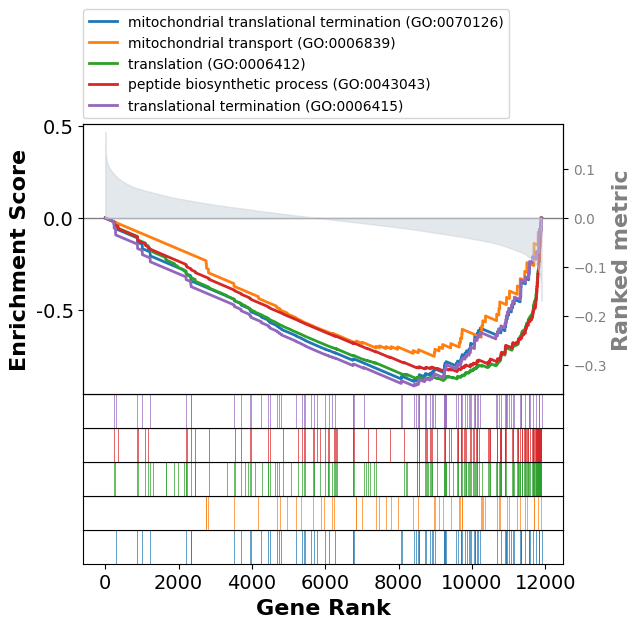

In [16]:

#assign negative and other 
adata_esr1=adata_rna[adata_rna.obs["guide_id"].isin(["ESR1_MP","non-targeting_Control"])] 
# ,"ESR1_AP"
res = gp.gsea(data=adata_esr1.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=adata_esr1.obs.guide_id,
        permutation_num=1000, 
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])
plt.savefig("esr1_gsea_p1.pdf", format="pdf", bbox_inches="tight")


In [17]:

#assign negative and other 
adata_esr1=adata_rna[adata_rna.obs["guide_id"].isin(["ESR1_MP","ESR1_AP"])] 
# ,"ESR1_AP"
res = gp.gsea(data=adata_esr1.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=adata_esr1.obs.guide_id,
        permutation_num=1000, 
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])
plt.savefig("esr1_gsea_p1_p2.pdf", format="pdf", bbox_inches="tight")


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 40, 42, 53, 54, 68, 70, 71, 72, 75, 76, 78, 80, 81, 82, 85, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'G', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 